In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
df = pd.read_csv("data/iwildcam_2022_results_v6.csv")
df = df.sort_values(by=["species", "Model", "threshold"])
ci = 95
eps = 0.02
model_labels = {
    "BP": "MacKenzie et al. (2002)",
    "BP_FP": "Royle and Link (2006)",
    "COP": "Pautrel et al. (2024)",
    "NAIVE": "Naive",
}
n_sites = df["Site"].nunique()

/data/vision/beery/scratch/timm/.local/lib/python3.11/site-packages/matplotlib/axes/_axes.py:6834: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/data/vision/beery/scratch/timm/.local/lib/python3.11/site-packages/matplotlib/axes/_axes.py:6835: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
/data/vision/beery/scratch/timm/micromamba/envs/zorrilla/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


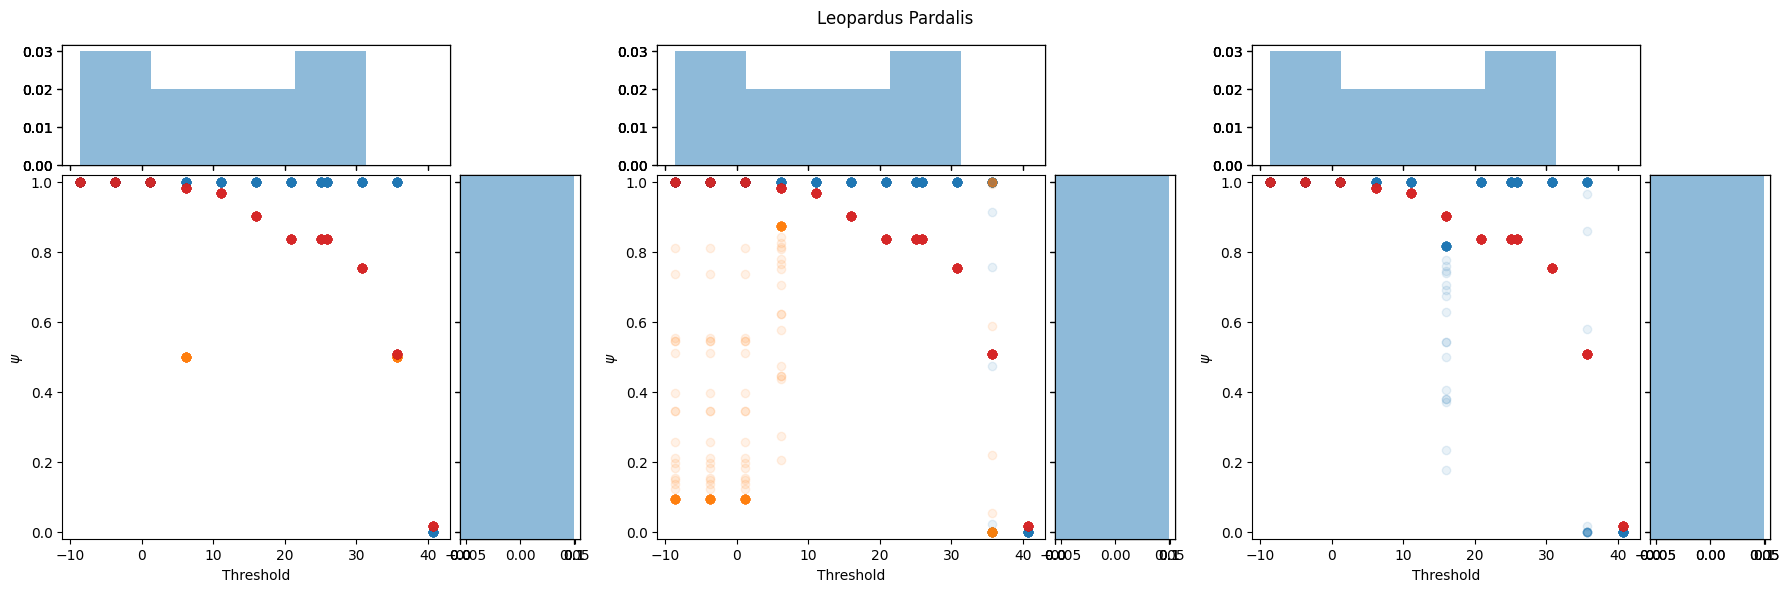

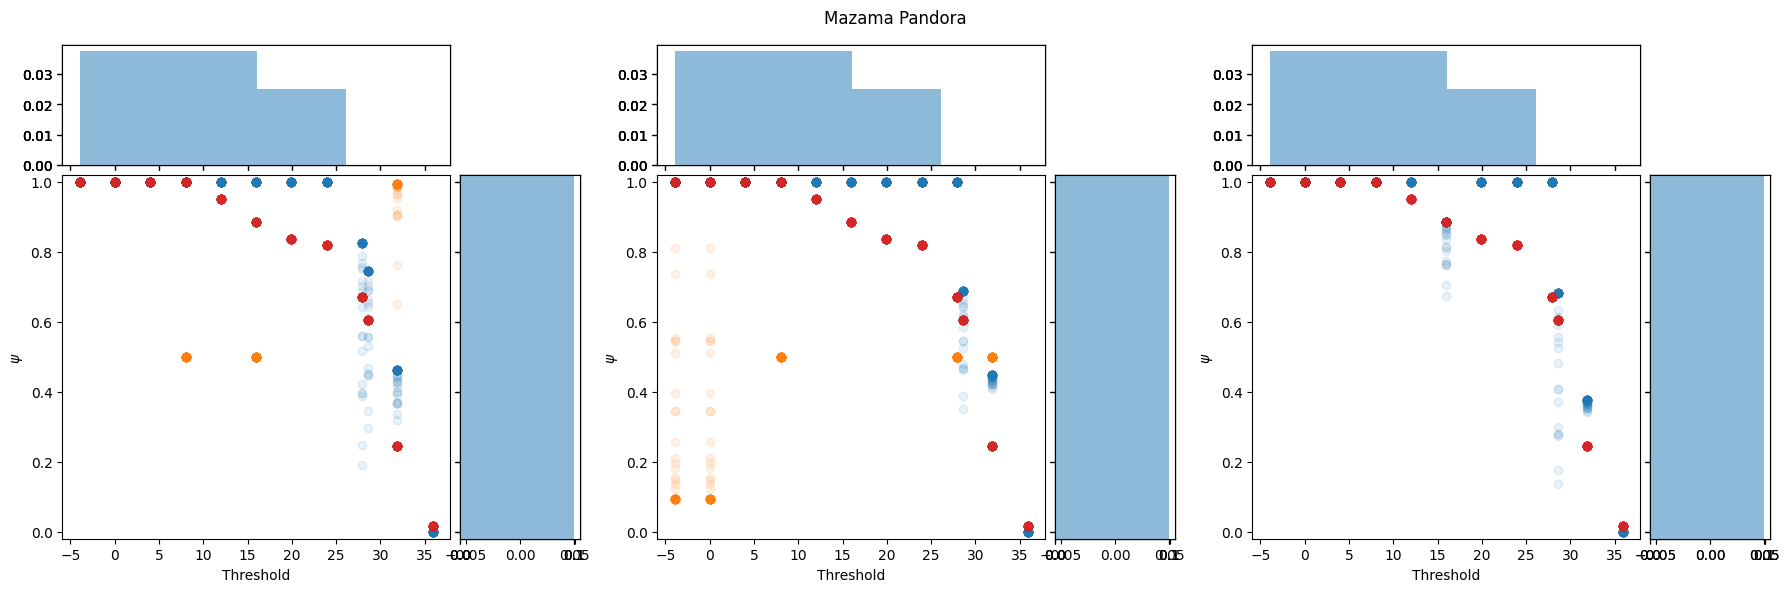

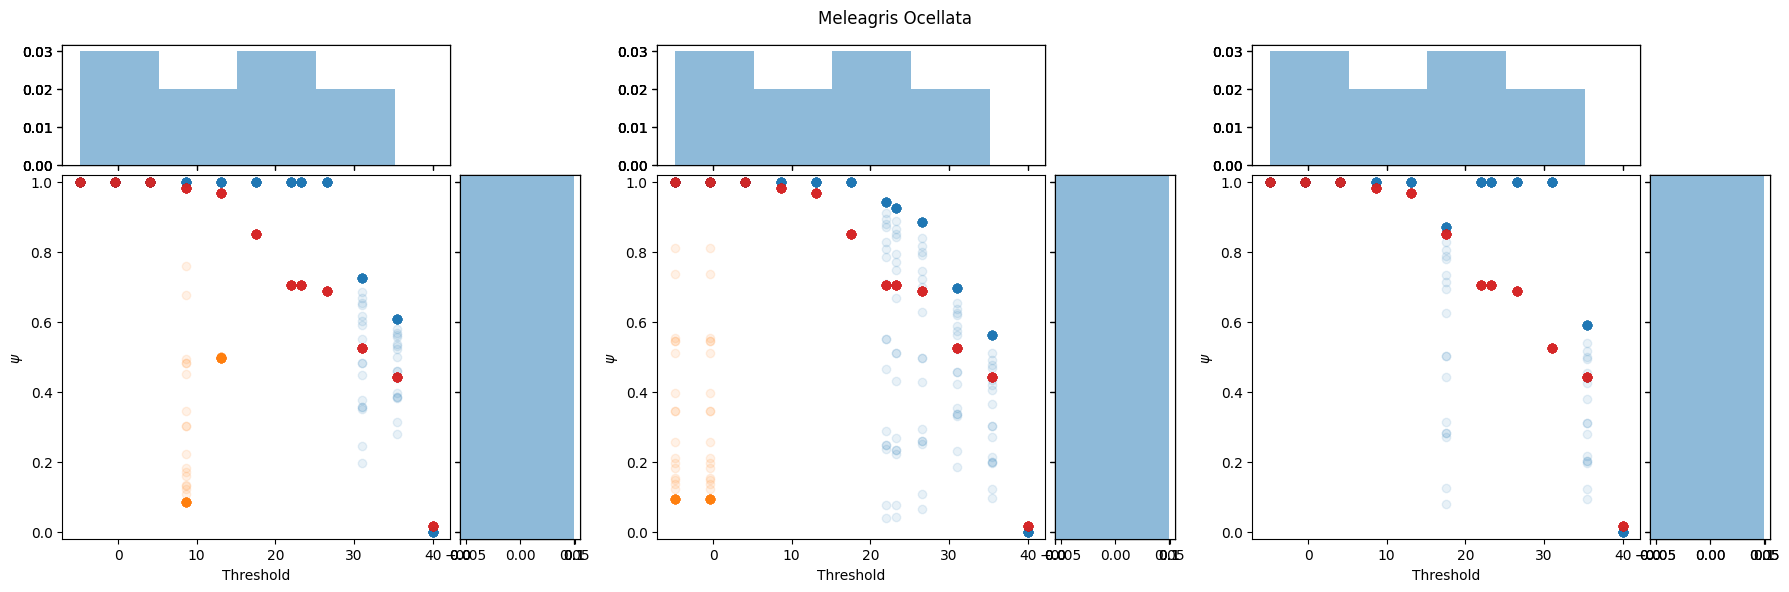

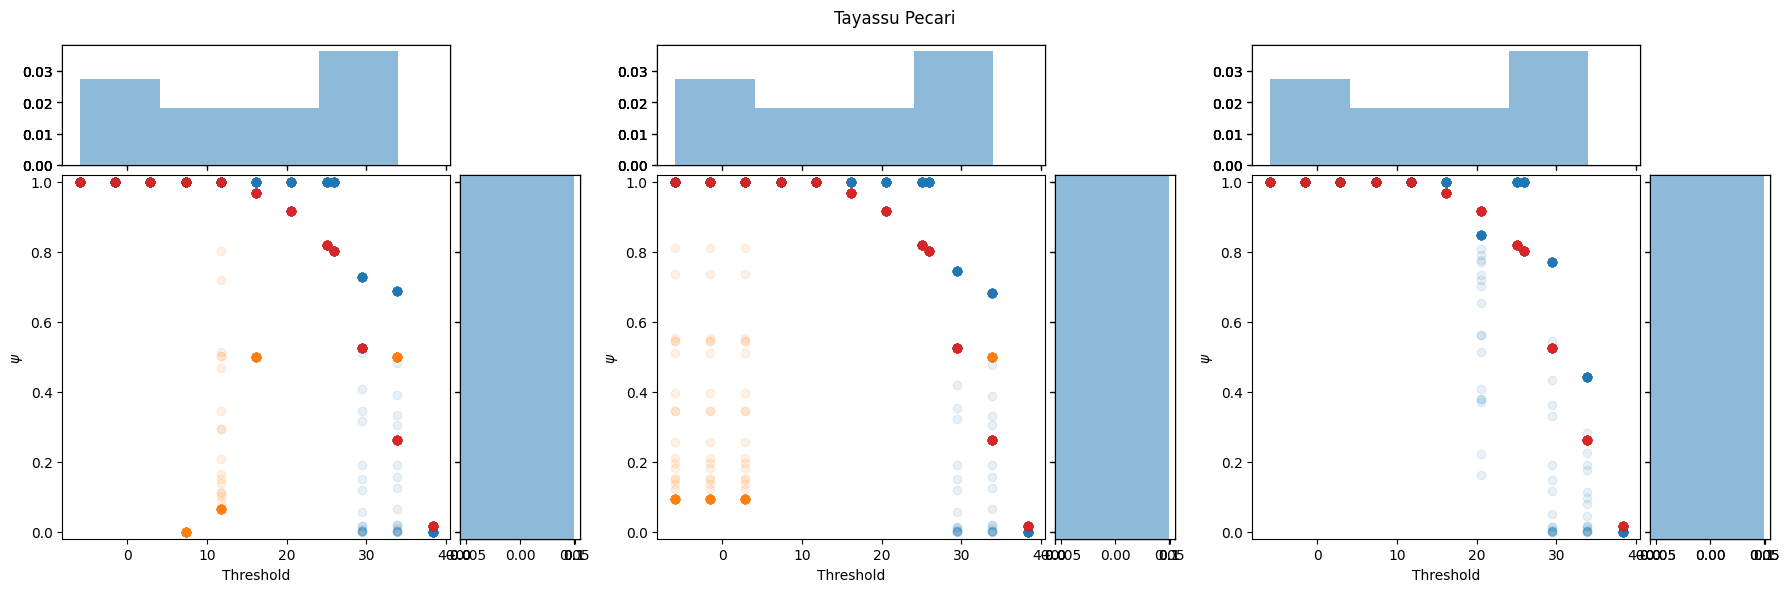

In [3]:
figs = []
for species in df["species"].unique():
    fig, axes = plt.subplots(1, df["Discretisation"].nunique(), figsize=(18, 6)); figs.append(fig)
    for discretisation, ax in zip(df["Discretisation"].unique(), axes):
        mask_species_discretization = (df["species"] == species) & (df["Discretisation"] == discretisation)
        for model in df["Model"].unique():
            mask_sampled = (df["Model"] == model) & (df["species"] == species) & (df["Discretisation"] == discretisation)
            mask = mask_sampled & (df["threshold_type"] != "gt")
            thresholds = sorted(df[mask]["threshold"].unique())

            # the scatter plot:
            x = df[mask]["threshold"]
            y = df[mask]["Predicted"]
            ax.scatter(x, y, alpha=0.1, label=model)

            ax.set_xlabel("Threshold")
            ax.set_ylabel(r"$\psi$")

            # Set aspect of the main Axes.
            # ax.set_aspect(1.)
            ax.set_ylim(0 - eps, 1 + eps)

            # create new Axes on the right and on the top of the current Axes
            divider = make_axes_locatable(ax)
            # below height and pad are in inches
            ax_histx = divider.append_axes("top", 1.2, pad=0.1, sharex=ax)
            ax_histy = divider.append_axes("right", 1.2, pad=0.1, sharey=ax)

            # make some labels invisible
            ax_histx.xaxis.set_tick_params(labelbottom=False)
            ax_histy.yaxis.set_tick_params(labelleft=False)

            if len(x) > 0:
                bins = np.arange(x.min(), x.max(), 10)
                ax_histx.hist(x, bins=bins, density=True, alpha=0.5, label=model)
                ax_histy.hist(y, bins=bins, density=True, alpha=0.5, label=model, orientation='horizontal')
    fig.suptitle(species.title().replace("_", " "))
    fig.tight_layout()
plt.show()
for fig in figs:
    os.makedirs("figures_v3/scatter", exist_ok=True)
    fig.savefig(f"figures_v3/scatter/{species}.pdf", bbox_inches="tight", transparent=True)
    fig.clear()

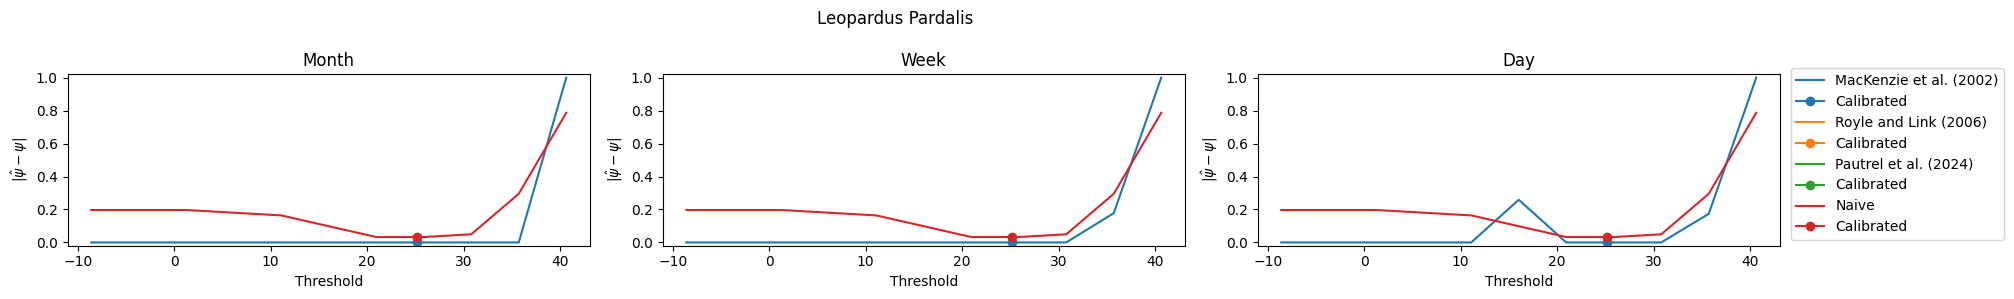

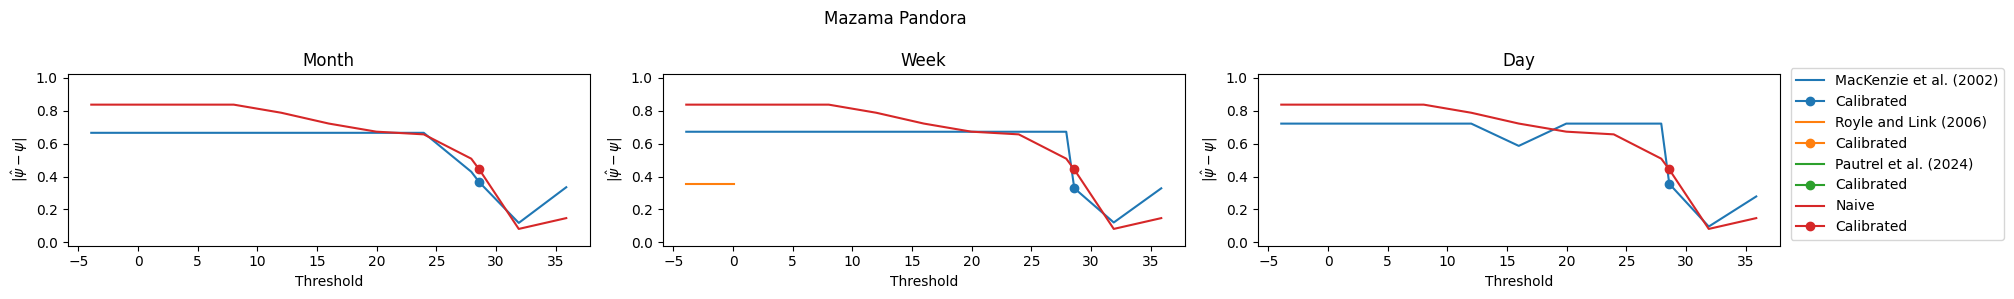

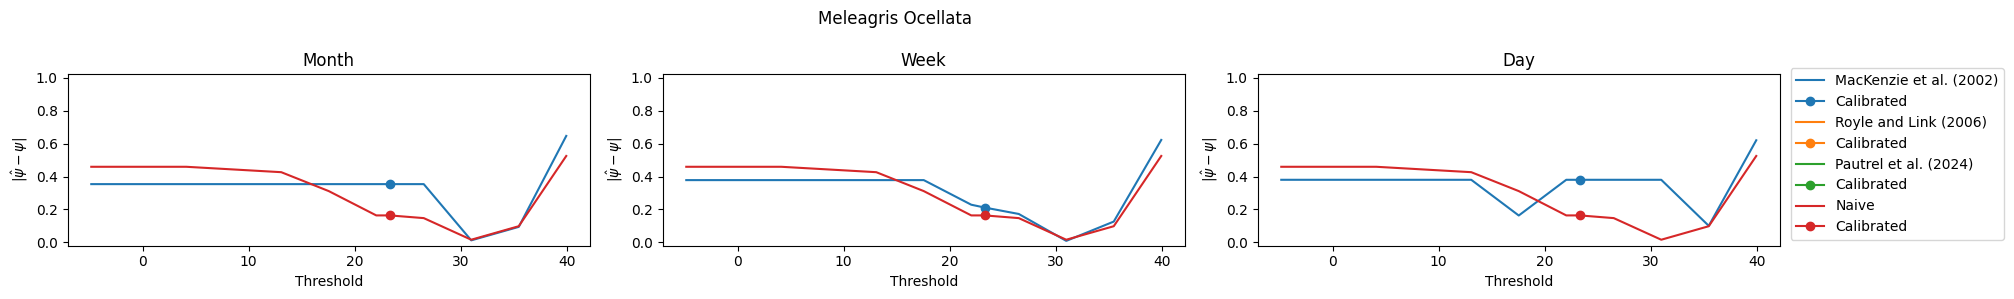

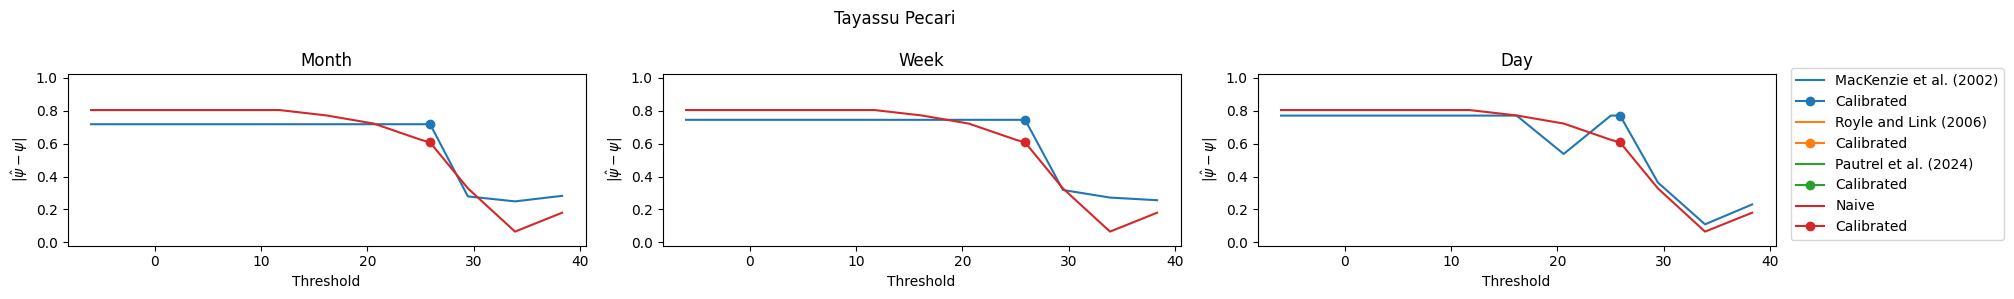

In [4]:
figs = []
for species in df["species"].unique():
    fig, axes = plt.subplots(1, df["Discretisation"].nunique(), figsize=(18, 3)); figs.append(fig)
    for discretisation, ax in zip(df["Discretisation"].unique(), axes):
        mask_species_discretization = (df["species"] == species) & (df["Discretisation"] == discretisation)
        for model in df["Model"].unique():
            mask_sampled = (df["Model"] == model) & (df["species"] == species) & (df["Discretisation"] == discretisation)
            mask = mask_sampled & (df["threshold_type"] != "gt")
            thresholds = sorted(df[mask]["threshold"].unique())
            abs_gt_error = []
            calibrated_abs_gt_error = float("NaN")
            for threshold in thresholds:
                gt_mask = mask_sampled & (df["threshold_type"] == "gt")
                pred_mask = mask_sampled & (df["threshold"] == threshold) & (df["threshold_type"] != "gt")
                if gt_mask.sum() != n_sites or pred_mask.sum() != n_sites:
                    abs_gt_error_threshold = []
                else:
                    gt_error_threshold = (df[gt_mask]["Predicted"].to_numpy() - df[pred_mask]["Predicted"].to_numpy())
                    abs_gt_error_threshold = np.abs(gt_error_threshold)
                abs_gt_error.append(np.mean(abs_gt_error_threshold))
                if (df[mask_sampled & (df["threshold_type"] == "calibrated")]["threshold"] == threshold).all():
                    calibrated_abs_gt_error = np.mean(abs_gt_error_threshold)
            if mask.sum() == 0:
                continue
            p = ax.plot(thresholds, abs_gt_error, label=model_labels.get(model, model))
            ax.set_xlabel("Threshold")
            ax.set_ylabel(r"$|\hat{\psi} - \psi|$")
            # ax.fill_between(df[mask]["threshold"], df[mask][f"psi_CI{ci}lower"], df[mask][f"psi_CI{ci}upper"], color=p[0].get_color(), alpha=0.1)
            if (mask & (df["threshold_type"] == "calibrated")).sum() > 0:
                ax.plot(df[mask & (df["threshold_type"] == "calibrated")]["threshold"].iloc[0], [calibrated_abs_gt_error], color=p[0].get_color(), marker="o", label="Calibrated")
            # p = ax.plot(df[mask_species_discretization]["threshold"], [df[mask_sampled & (df["threshold_type"] == "gt")]["true_mean_psi"]] * mask_species_discretization.sum(), color=p[0].get_color(), linestyle="dashed", label="Ground Truth Labels")
            ax.set_ylim(0 - eps, 1 + eps)
            ax.set_title(discretisation)
            # ax.legend()
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="center right", bbox_to_anchor=(0.12, 0, 1, 1), bbox_transform=fig.transFigure)
    fig.suptitle(species.title().replace("_", " "))
    fig.tight_layout()
plt.show()
for fig in figs:
    os.makedirs("figures_v3/abs_gt_error", exist_ok=True)
    fig.savefig(f"figures_v3/abs_gt_error/{species}.pdf", bbox_inches="tight", transparent=True)
    fig.clear()

In [5]:
# figs = []
# for species in df["species"].unique():
#     fig, axes = plt.subplots(1, df["Discretisation"].nunique(), figsize=(18, 3)); figs.append(fig)
#     for discretisation, ax in zip(df["Discretisation"].unique(), axes):
#         for model in df["Model"].unique():
#             mask_sampled = (df["Model"] == model) & (df["species"] == species) & (df["Discretisation"] == discretisation)
#             mask = mask_sampled & (df["threshold_type"] != "gt")
#             if mask.sum() == 0:
#                 continue
#             p = ax.plot(df[mask]["threshold"], df[mask]["p_PointEstimate"], label=model_labels.get(model, model))
#             ax.set_xlabel("Threshold")
#             ax.set_ylabel("P")
#             # ax.fill_between(df[mask]["threshold"], df[mask][f"p_CI{ci}lower"], df[mask][f"psi_CI{ci}upper"], color=p[0].get_color(), alpha=0.1)
#             p = ax.plot(df[mask]["threshold"], [df[mask_sampled & (df["threshold_type"] == "gt")]["abs_gt_error"]] * mask.sum(), color=p[0].get_color(), linestyle="dashed", label="Ground Truth Labels")
#             ax.set_ylim(0, 1)
#             ax.set_title(discretisation)
#             # ax.legend()
#     handles, labels = axes[0].get_legend_handles_labels()
#     fig.legend(handles, labels, loc="center right", bbox_to_anchor=(0.04, 0, 1, 1), bbox_transform=fig.transFigure)
#     fig.suptitle(species.title().replace("_", " "))
# plt.show()
# for fig in figs:
#     os.makedirs("figures_v3/p", exist_ok=True)
#     fig.savefig(f"figures_v3/p/{species}.pdf", bbox_inches="tight", transparent=True)
#     fig.clear()

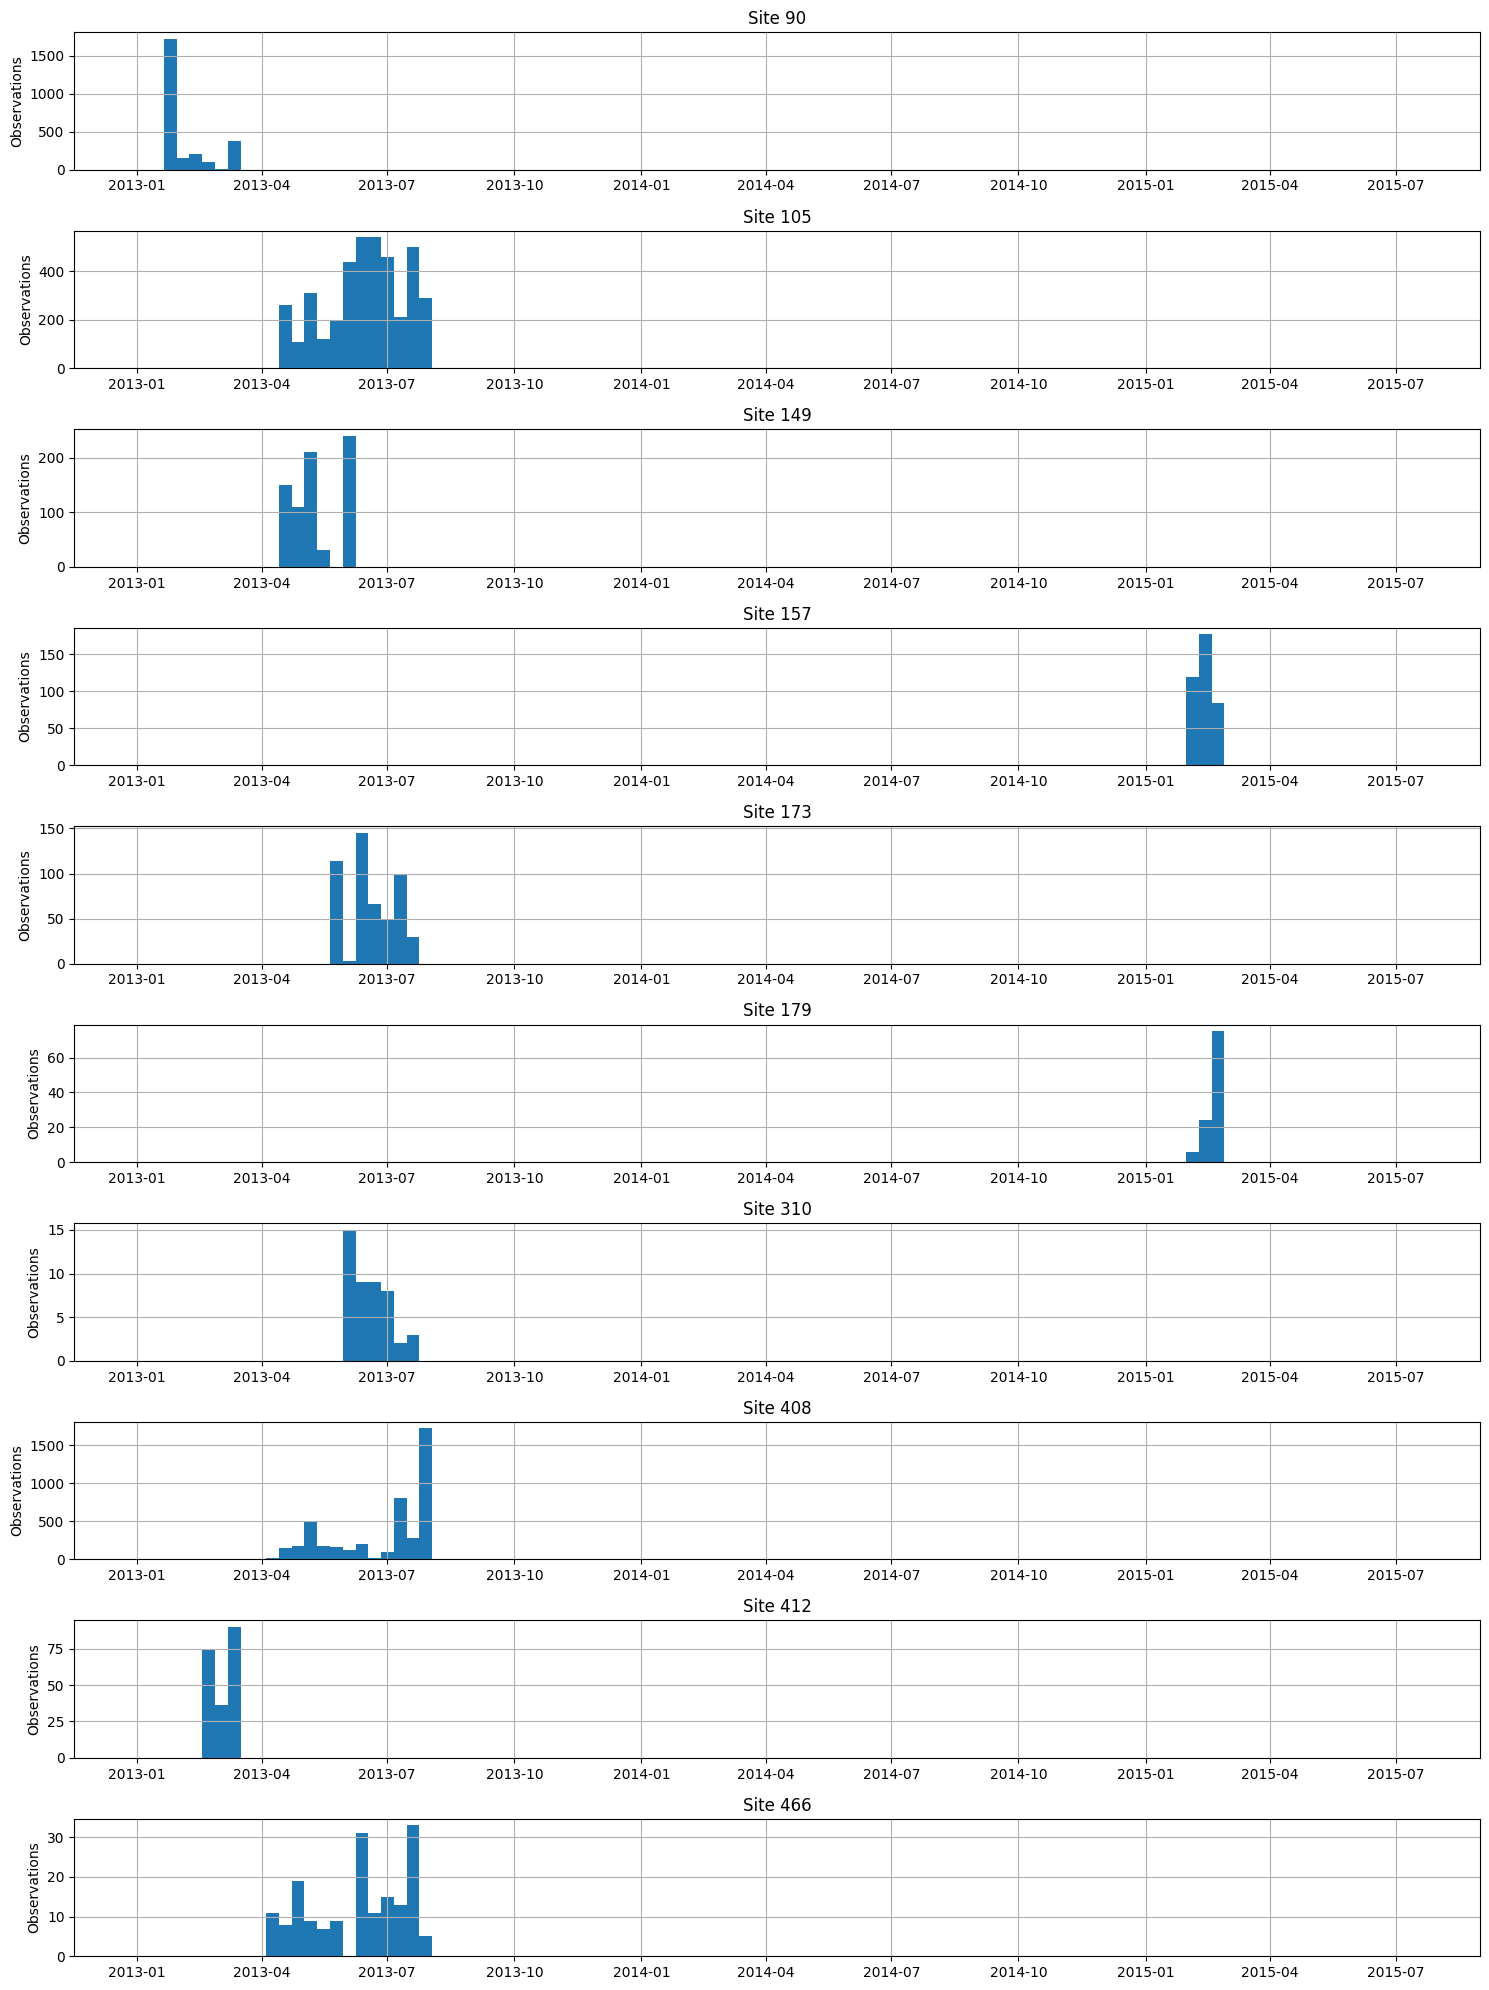

In [6]:
dfr = pd.read_csv("../data/iwildcam_2022_crops_bioclip_inference_logits_v3.csv")
dfr["datetime"] = pd.to_datetime(dfr["datetime"])
start, end = dfr["datetime"].min(), dfr["datetime"].max()
locs = np.sort(np.random.default_rng(seed=42).choice(dfr["location"].unique(), 10))
fig, axes = plt.subplots(len(locs), 1, figsize=(15, 20))
for location, ax in zip(locs, axes):
    dfr[dfr["location"] == location].hist(column="datetime", bins=100, ax=ax, range=(start, end))
    ax.set_title(f"Site {location}")
    ax.set_ylabel("Observations")
fig.tight_layout()
fig.savefig("figures/site_samples_over_time.pdf", transparent=True, bbox_inches="tight")